# Notebook settings
This notebook is a universal frame for training the BERT + Adapted C-HMCNN model. It can take in any Parquet dataset with suitable configuration.

In [67]:
### Dataset configuration
# The parquet folder. It should be located inside datasets/.
DATASET_NAME   = 'Walmart_30k.parquet'
# The input text column
TEXT_COL_NAME  = 'title'
# Which column to use as labelled classes. It should be a column of lists of strings.
CLASS_COL_NAME = 'category'
# How many hierarchical levels to work on. Note that the dataset must also have at least this many levels for every example.
DEPTH = 2

### Checkpoint configuration
# Whether to train from scratch or to load a checkpoint
TRAIN_FROM_SCRATCH=True
# Checkpoint iteration to load if not training from scratch
LOAD_ITERATION=0
# Last or best results from that iteration?
LOAD_BEST=True

### System configuration
# Will try to use your NVIDIA GPU if one is available. Set to False to force CPU computation
PREFER_GPU         = True
# If you don't have the batchrenorm pip package installed for the current env, flip this to True. 
CLONE_BATCH_RENORM = False
# If you don't have the huggingface transformers library installed, flip this to True.
# You only need to do this once. Once DistilBERT has been downloaded, it will be cached in your system's default user cache folder.
# Once it is cached, please set this to False to avoid redownloads.
INSTALL_DISTILBERT = False

# Import common libraries
And also set up a few things.

In [68]:
import dask.dataframe as dd
import numpy as np
import torch
from tqdm.notebook import tqdm
import numpy as np
import shutil, sys
from sklearn import metrics
import os

# Set up GPU if available
device = 'cuda' if torch.cuda.is_available() and PREFER_GPU else 'cpu'
print('Using', device)

# Batch renormalisation
if CLONE_BATCH_RENORM:
    !pip install git+https://github.com/ludvb/batchrenorm@master
from batchrenorm import BatchRenorm1d

Using cuda


# Import data
We use Parquet datasets, stored inside the `datasets` folder of this repository.

In [69]:
data = dd.read_parquet('../../datasets/{}'.format(DATASET_NAME))
data.head(10)

,title,description,List Price,Sale Price,Brand,category
0,"La Costena Chipotle Peppers, 7 OZ (Pack of 12)","La Costena Chipotle Peppers, 7 OZ (Pack of 12)...",31.93,31.93,La Costeï¿½ï¿½a,"[Food, Meal Solutions, Grains & Pasta, Canned ..."
1,Equate Triamcinolone Acetonide Nasal Allergy S...,Compare to Nasacort Allergy 24HR active ingred...,10.48,10.48,Equate,"[Health, Equate, Equate Allergy, Equate Sinus ..."
2,AduroSmart ERIA Soft White Smart A19 Light Bul...,The Soft White ERIA A19 bulb (2700K) can be co...,10.99,10.99,AduroSmart ERIA,"[Electronics, Smart Home, Smart Energy and Lig..."
3,"24"" Classic Adjustable Balloon Fender Set Chro...","Lowrider Fender Set 24"" Classic Adjustable Chr...",38.59,38.59,lowrider,"[Sports & Outdoors, Bikes, Bike Accessories, B..."
4,Elephant Shape Silicone Drinkware Portable Sil...,This is a kind of fine quality silicone cup l...,5.81,5.81,Anself,"[Baby, Feeding, Sippy Cups: Alternatives to Pl..."
5,(6 Boxes) Twinings of London Nightly Calm Gree...,Enojy one of your favorite tea flavors with th...,17.99,17.99,Twinings,"[Food, Beverages, Tea, All Tea]"
6,"Toytainer Shoe Box Play-N-Store, Boy","Toytainer Shoe Box Play-N-Store, Boy: Teach y...",11.52,11.52,Toytainer,"[Home, Kids Rooms, Kids Storage]"
7,Dometic D1112002 D Line 3 N 1 Bowl Cleaner and...,Dometic D Line 3 N 1 Cleaner and Tank Treatmen...,34.41,34.41,Dometic,"[Household Essentials, Bathroom, Bathroom Clea..."
8,"Tiny White Mighty Mints (16 oz, ZIN: 525424) -...","Tiny White Mighty Mints (16 oz, ZIN: 525424): ...",16.54,16.54,Larissa Veronica,"[Food, Chocolate, Candy & Gum, Mints, Shop All..."
9,Diabetic Socks Small White - Item Number 11600...,Diabetic Socks Small White - Item Number 11600...,13.76,13.76,DJO,"[Health, Diabetes Care, Diabetic Socks]"


# Prepare category hierarchy

## Categorical-encode the classes
Classification will be done by C-HMCNN (our own implementation). For this to work, we need a one-hot-encoded label set, which is compatible with BCELoss. We also extract the numerical labels for those classes from the one-hot encodings for convenience (i.e. for rendering a human-readable test output and to build the hierarchy from the list of name strings).

For categorical encoding to work, the column itself must be in Dask's `category` datatype, instead of the default `object` type for non-numerical columns.

To ease parsing, we'll follow a HMCN-like scheme in which labels are clumped together by their levels, i.e. the order would be all labels on level 1, then followed by all labels on level 2, and so on.

In [70]:
def preprocess_classes(data, original_name, depth, verbose=False):
    """
    Build a list of unique class names for each level and create bidirectional mappings.
    """
    cls2idx = []
    idx2cls = []
    for i in range(depth): 
        category_li = data[original_name].apply(
            lambda lst: lst[i], meta=(original_name, 'object')
        ).astype('category').cat.as_known()
        if verbose:
            print(category_li.cat.categories)
        cls2idx.append(dict([
            (category, index) 
            for (index, category) 
            in enumerate(category_li.cat.categories)
        ]))
        idx2cls.append(list(category_li.cat.categories))
    return cls2idx, idx2cls

def class_to_index(data, original_name, cls2idx, depth):
    data['codes'] = data[original_name].apply(
        lambda lst: [
            cls2idx[i][cat] 
            for (i, cat) 
            in enumerate(lst[:depth])
        ],
        meta=(original_name, 'object')
    ).astype('object')

cls2idx, idx2cls = preprocess_classes(data, CLASS_COL_NAME, DEPTH)
    
print('Class-to-index mapping:', cls2idx, '\n')
print('Index-to-class mapping:', idx2cls, '\n')

# Now take those mappings and convert those class names to numbers
class_to_index(data, CLASS_COL_NAME, cls2idx, DEPTH)

print('Data preview:', data['codes'].head(10))

Class-to-index mapping: [{'Arts Crafts & Sewing': 0, 'Auto & Tires': 1, 'Baby': 2, 'Beauty': 3, 'Books': 4, 'Cell Phones': 5, 'Character Shop': 6, 'Clothing': 7, 'Collectibles': 8, 'Electronics': 9, 'Feature': 10, 'Food': 11, 'Health': 12, 'Home': 13, 'Home Improvement': 14, 'Household Essentials': 15, 'Industrial & Scientific': 16, 'Jewelry': 17, 'Music': 18, 'Musical Instruments': 19, 'Office Supplies': 20, 'Party & Occasions': 21, 'Patio & Garden': 22, 'Personal Care': 23, 'Pets': 24, 'Premium Beauty': 25, 'Seasonal': 26, 'Sports & Outdoors': 27, 'Toys': 28, 'Video Games': 29, 'Walmart for Business': 30}, {'2-in-1 Hair and Body Care': 0, '@ Manual Shelves - Beauty': 1, '@ Manual Shelves - Food': 2, 'ATV & Off-Road': 3, 'Acid Reflux': 4, 'Action Figures': 5, 'Advance Auto Parts Shop': 6, 'Air Fresheners': 7, 'All Industrial': 8, 'Allergy and Sinus': 9, 'Appliances': 10, 'Aromatherapy': 11, 'Art Supplies': 12, 'Arts & Crafts for Kids': 13, 'As Seen On TV': 14, 'Audio': 15, 'Auto Body'

Data preview: 0    [11, 168]
1     [12, 95]
2     [9, 249]
3     [27, 47]
4     [2, 104]
5     [11, 45]
6    [13, 153]
7     [15, 34]
8     [11, 63]
9     [12, 79]
Name: codes, dtype: object


In [71]:
from functools import reduce
# C-HMCNN needs global-space indices. As such we need to offset the level codes.
# We still make use of the local-space code above to increase commonality with other models.
def index_to_binary(data, index_col_name, offsets, sz, verbose=False):
    if verbose:
        print('Using offsets:', offsets)
    
    def generate_binary(codes):
        b = np.zeros(sz, dtype=int)
        indices = np.array(codes, dtype=int) + offsets[:-1] - 1
        if verbose:
            print(codes, offsets, indices)
        b[indices] = 1
        return b.tolist()
    
    data[index_col_name + '_b'] = data[index_col_name].apply(
        lambda lst: generate_binary(lst),
        meta=(index_col_name + '_b', 'object')
    )
    
level_sizes = [*map(lambda lst: len(lst), idx2cls)]
level_offsets = np.array(reduce(lambda acc, elem: acc + [acc[-1] + elem], level_sizes, [0]))
index_to_binary(data, 'codes', level_offsets, sum(level_sizes), verbose=False)

print(data['codes_b'].head(10))

0    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...
1    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...
2    [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...
3    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
4    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
5    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...
6    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...
7    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...
8    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...
9    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...
Name: codes_b, dtype: object


## Build an ancestry matrix
Let $n_D$ = number of classes we have up to depth $D$ of the hierarchy, build a matrix $M_D$ of size $n_D \times n_D$ where $M_{i,j} = 1$ if label with code $i$ is an ancestor of label with code $j$ and 0 otherwise.

For example in an e-commerce product dataset, if a category named 'Sports' of code 0 has a subcategory named 'Outdoor Sports' of code 100, then $M_{0, 100} = 1$. Intuitively, every row represents the parentship of each category.

One important thing to note here is that the set of subclasses contains the parent class itself. This is key to C-HMCNN's ability to uphold the hierarchy.

In [72]:
def build_ancestry_matrix(codes, level_sizes):
    n = sum(level_sizes)
    offsets = np.array([0] + level_sizes, dtype=int)
    result = np.zeros((n, n), dtype=bool)
    np.fill_diagonal(result, 1) # In our case, every category is an ancestor of itself
    for lst in tqdm(codes):
        for i, ancestor in enumerate(lst):
            ancestor_idx = ancestor + offsets[i] - 1
            for j, offspring in enumerate(lst[i+1:]):
                offspring_idx = offspring + offsets[j+i+1] - 1
                result[ancestor_idx, offspring_idx] = 1
    return result

# Pass n separately for easier Dask integration later, as iloc doesn't work
M = build_ancestry_matrix(data['codes'], level_sizes)
M = torch.tensor(M).to(device)
M

  0%|          | 0/29206 [00:00<?, ?it/s]

tensor([[ True, False, False,  ..., False, False, False],
        [False,  True, False,  ..., False, False, False],
        [False, False,  True,  ..., False, False, False],
        ...,
        [False, False, False,  ...,  True, False, False],
        [False, False, False,  ..., False,  True, False],
        [False, False, False,  ..., False, False,  True]], device='cuda:0')

## Checkpoints

In [73]:
def load_checkpoint(checkpoint_fpath, model, optimizer=None):
    """
    checkpoint_fpath: path to save checkpoint
    model: model that we want to load checkpoint parameters into       
    optimizer: optimizer we defined in previous training
    """
    checkpoint = torch.load(checkpoint_fpath)
    model.load_state_dict(checkpoint['state_dict'])
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint['optimizer'])
        return model, optimizer
    return model

def save_checkpoint(state, is_best, checkpoint_path, best_checkpoint_path):
    """
    state: checkpoint we want to save
    is_best: is this the best checkpoint; min validation loss
    checkpoint_path: path to save checkpoint
    best_checkpoint_path: path to save best model
    """
    f_path = checkpoint_path
    torch.save(state, f_path)
    if is_best:
        best_fpath = best_checkpoint_path
        shutil.copyfile(f_path, best_fpath)

## Metrics function
We define hierarchical accuracy as simply the averaged accuracy over each level. Same for precision.
In addition to those, at the end of the testing phase we'll also compute the average area under the precision-recall curve (AU(PRC)).

In [74]:
def get_metrics(outputs, targets, level_sizes, print_metrics=True):
    offsets = [0] + level_sizes
    level_codes = [ 
        np.argmax(outputs[:, offsets[level] : offsets[level + 1]], axis=1) + offsets[level] 
        for level in range(len(level_sizes)) 
    ]
    
    target_codes = np.array([ np.nonzero(lst)[0] for lst in targets ], dtype=int)
    
    accuracies = [ metrics.accuracy_score(level_codes[level], target_codes[:, level]) for level in range(len(level_sizes)) ]
    precisions = [ metrics.precision_score(level_codes[level], target_codes[:, level], average='weighted') for level in range(len(level_sizes)) ]
    
    global_accuracy = sum(accuracies)/len(accuracies)
    global_precision = sum(precisions)/len(precisions)
    
    if print_metrics:
        for i in range(len(level_sizes)):
            print('Level {}:'.format(i))
            print("Accuracy:", accuracies[i])
            # Model Precision: what percentage of positive tuples are labeled as such?
            print("Precision:", precisions[i],'\n')
        print('Path average:')
        print('Accuracy:', global_accuracy)
        print('Precision:', global_precision)
    
    return np.array([accuracies[-1], precisions[-1], global_accuracy, global_precision])

# Data and model preparation

## Installing DistilBERT
Alternative to full-fat BERT, roughly matching its performance while being faster.

In [75]:
if not INSTALL_DISTILBERT:
    os.environ['TRANSFORMERS_OFFLINE'] = '1'
else:
    !pip install transformers
    
import transformers as ppb
tokenizer = ppb.DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
base_encoder = ppb.DistilBertModel.from_pretrained('distilbert-base-uncased')
base_encoder_state = base_encoder.state_dict()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Define our dataset adapter class
This wraps around our data and provides a PyTorch-compatible interface.

In [76]:
from torch.utils.data import Dataset
class CustomDataset(Dataset):
    def __init__(self, df, tokenizer, max_len, text_col_name = TEXT_COL_NAME):
        self.tokenizer = tokenizer
        self.text = df[text_col_name]
        self.labels = df['codes_b']
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text.iloc[index])
        text = " ".join(text.split())
        inputs = self.tokenizer(
            text,
            None, # No text_pair
            add_special_tokens=True, # CLS, SEP
            max_length=self.max_len, # For us it's a hyperparam. See next cells.
            padding='max_length',
            truncation=True
            # BERT tokenisers return attention masks by default
        )
        return {
            'ids': torch.tensor(inputs['input_ids'], dtype=torch.long),
            'mask': torch.tensor(inputs['attention_mask'], dtype=torch.long),
            'labels': torch.tensor(self.labels.iloc[index], dtype=torch.float)
        }

Regarding that `max_len` hyperparameter, let's see the distribution of string lengths:

/usr/lib/python3.9/site-packages/dask/dataframe/core.py:3718: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('title', 'int64'))

  warnings.warn(meta_warning(meta))


<AxesSubplot:>

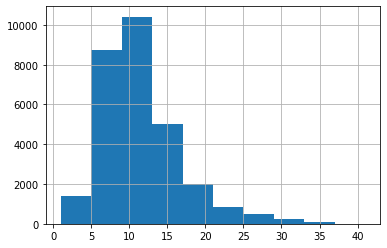

In [77]:
data[TEXT_COL_NAME].apply(lambda s: len(s.split())).compute().hist()

We prefer `max_len` to be a power of two that covers most of the strings. Here it seems 64 will do.

In [78]:
###
### TUNING HYPERPARAMETERS?
### Simply adjust here then run this cell and those below it. No need to run those above.
###

folder_name = 'checkpoints-' + DATASET_NAME
!mkdir $folder_name
CHECKPOINT_IDX = len(os.listdir(folder_name)) // 2
CHECKPOINT_PATH = './{}/{}_current.pt'.format(folder_name, CHECKPOINT_IDX)
BEST_CHECKPOINT_PATH = './{}/{}_best.pt'.format(folder_name, CHECKPOINT_IDX)

# Customize these settings for training from scratch.
config = {
    'epochs': 5,
    'encoder_lr': 2e-05,
    'classifier_lr': 5e-04,
    'h_dropout': 0.7,
    'h_nonlinear': 'relu',
    'h_hidden_dim': 512,
    'h_layer_count': 3,
}

### Don't change these if you need to compare with published results
MAX_LEN = 64
TRAIN_SET_RATIO = 0.8
VAL_SET_RATIO = 0.1
# The rest is test set
RANDOM_SEED = 123
# Flip to False for faster hyperparameter tuning. If False, only 5% of the full dataset is used. 
FULL_SET = True

TRAIN_MINIBATCH_SIZE = 16
VAL_TEST_MINIBATCH_SIZE = 64

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
mkdir: cannot create directory ‘checkpoints-Walmart_30k.parquet’: File exists


In [79]:
small_data = None
if not FULL_SET:
    small_data = data.sample(frac = 0.05, random_state=RANDOM_SEED)

train_set = None
test_set = None

COLUMNS = [TEXT_COL_NAME, 'codes_b']

filtered = None
if FULL_SET:
    filtered = data[COLUMNS].compute()
else:
    filtered = small_data[COLUMNS].compute()

train_set = filtered.sample(frac = TRAIN_SET_RATIO, random_state=RANDOM_SEED)
val_test_set = filtered.drop(train_set.index)

val_set = val_test_set.sample(frac = VAL_SET_RATIO / (1-TRAIN_SET_RATIO), random_state=RANDOM_SEED)
test_set = val_test_set.drop(val_set.index)

train_set = train_set.reset_index(drop=True)
val_set = val_set.reset_index(drop=True)
test_set = test_set.reset_index(drop=True)

print(train_set.shape)
print(val_set.shape)
print(test_set.shape)

(23365, 2)
(2921, 2)
(2920, 2)


We can now wrap them in our Datasets, and then into PyTorch's DataLoaders.

In [80]:
train_set_wrapped = CustomDataset(train_set, tokenizer, MAX_LEN)
val_set_wrapped = CustomDataset(val_set, tokenizer, MAX_LEN)
test_set_wrapped = CustomDataset(test_set, tokenizer, MAX_LEN)
train_loader = torch.utils.data.DataLoader(dataset=train_set_wrapped, batch_size=TRAIN_MINIBATCH_SIZE, shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(dataset=val_set_wrapped, batch_size=VAL_TEST_MINIBATCH_SIZE, shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(dataset=test_set_wrapped, batch_size=VAL_TEST_MINIBATCH_SIZE, shuffle=True, num_workers=0)

Test run:

In [81]:
test_batch = next(iter(test_loader))
test_batch

{'ids': tensor([[  101, 12636,  2078,  ...,     0,     0,     0],
         [  101,  1006,  1002,  ...,     0,     0,     0],
         [  101,  3103, 22779,  ...,     0,     0,     0],
         ...,
         [  101,  9388,  4645,  ...,     0,     0,     0],
         [  101,  3998, 20702,  ...,     0,     0,     0],
         [  101,  7605, 15360,  ...,     0,     0,     0]]),
 'mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 'labels': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]])}

## Prepare the model itself
Here we use DistilBERT as the encoding layers, followed by a dropout layer and a linear layer for leaf category classification.

In [82]:
def get_constr_out(x, M):
    n = M.shape[1]
    H = x.unsqueeze(1) # Add a new dimension
    # Duplicate x along the new dimension to create a list of 2D matrices
    # of size n x n (same as R). Note that x can be a list of vectors instead of one.
    H = H.expand(len(x), n, n)
    # We'll have to duplicate R to multiply with the entire batch here
    M_batch = M.expand(len(x), n, n)
    final_out, _ = torch.max(M_batch*H, dim = 2)
    return final_out

class H_MCM_Model(torch.nn.Module):
    def __init__(self, input_dim, output_dim, config, M):
        super(H_MCM_Model, self).__init__()

        self.layer_count = config['h_layer_count']
        self.M = M

        fc = []
        if self.layer_count == 1:
            fc.append(torch.nn.Linear(input_dim, output_dim))
        else:
            for i in range(self.layer_count):
                if i == 0:
                    fc.append(torch.nn.Linear(input_dim, config['h_hidden_dim']))
                elif i == self.layer_count - 1:
                    fc.append(torch.nn.Linear(config['h_hidden_dim'], output_dim))
                else:
                    fc.append(torch.nn.Linear(config['h_hidden_dim'], config['h_hidden_dim']))

        self.fc = torch.nn.ModuleList(fc)    
        self.drop = torch.nn.Dropout(config['h_dropout'])
        self.sigmoid = torch.nn.Sigmoid()
        if config['h_nonlinear'] == 'tanh':
            self.f = torch.nn.Tanh()
        else:
            self.f = torch.nn.ReLU()

    def forward(self, x):
        for i in range(self.layer_count):
            if i == self.layer_count - 1:
                x = self.sigmoid(self.fc[i](x))
            else:
                x = self.f(self.fc[i](x))
                x = self.drop(x)
        if self.training:
            return x
        return get_constr_out(x, self.M)

In [83]:
encoder = base_encoder
encoder.load_state_dict(base_encoder_state)
encoder.to(device)

class DistilBERTClass(torch.nn.Module):
    def __init__(self, output_count, M):
        super(DistilBERTClass, self).__init__()
        self.l1 = encoder
        self.renorm = BatchRenorm1d(768)
        self.l2 = torch.nn.Dropout(0.3)
        self.l3 = H_MCM_Model(768, output_count, config, M)
    def forward(self, ids, mask):
        output_1 = self.l1(ids, attention_mask = mask)[0][:,0,:]
        output_2 = self.l2(self.renorm(output_1))
        output = self.l3(output_2)
        return output

model = DistilBERTClass(sum(level_sizes), M)

model.to(device)

DistilBERTClass(
  (l1): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(in_featu

# Training time

In [84]:
#!/usr/bin/env python

from tqdm.notebook import tqdm

def train_model(config, train_loader, val_loader, model, checkpoint_path, best_checkpoint_path, level_sizes):
    
    output_sz = sum(level_sizes)
    
    criterion = torch.nn.BCELoss()

    optimizer = torch.optim.Adam(
        [
            {'params': model.l1.parameters(), 'lr': config['encoder_lr'],},
            {'params': model.l3.parameters(), 'lr': config['classifier_lr']}
        ], 
    )
    val_loss_min = np.Inf
    # Store validation metrics after each epoch
    val_metrics = np.empty((4, 0), dtype=float)
    for epoch in range(1, config['epochs'] + 1):
        train_loss = 0
        val_loss = 0
        # Put model into training mode. Note that this call DOES NOT train it yet.
        model.train()
        print('Epoch {}: Training'.format(epoch))
        for batch_idx, data in enumerate(tqdm(train_loader)):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            targets = data['labels'].to(device, dtype = torch.double)

            outputs = model(ids, mask)

            # Notation: H = output stacked, Hbar = hbar stacked
            constr_outputs = get_constr_out(outputs, M) # MCM = max(M * H, dim=1)
            train_outputs = targets * outputs.double() # hbar = y * h
            train_outputs = get_constr_out(train_outputs, M) # max(M * Hbar, dim = 1)

            # (1-y) + max(M * H, dim = 1) + y * max(M * Hbar, dim = 1) versus y
            train_outputs = (1-targets)*constr_outputs.double() + targets*train_outputs
            loss = criterion(train_outputs, targets)

            predicted = constr_outputs.data > 0.5

            # PyTorch defaults to accumulating gradients. That's half of what Adam is.
            # but we are working on a new batch each time this runs, so we still have
            # to clear.
            optimizer.zero_grad()

            loss.backward()
            optimizer.step()

            #print('before loss data in training', loss.item(), train_loss)
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.item() - train_loss))
            #print('after loss data in training', loss.item(), train_loss)

        print('Epoch {}: Validating'.format(epoch))

        # Switch to evaluation (prediction) mode. Again, this doesn't evaluate anything.
        model.eval()

        current_val_targets = np.empty((0, output_sz), dtype=np.float32)
        current_val_outputs = np.empty((0, output_sz), dtype=np.float32)
        # We're only testing here, so don't run the backward direction (no_grad).
        with torch.no_grad():
            for batch_idx, data in enumerate(val_loader, 0):
                ids = data['ids'].to(device, dtype = torch.long)
                mask = data['mask'].to(device, dtype = torch.long)
                targets = data['labels'].to(device, dtype = torch.double)

                constrained_outputs = model(ids, mask).double()

                loss = criterion(constrained_outputs, targets)

                val_loss = val_loss + ((1 / (batch_idx + 1)) * (loss.item() - val_loss))

                current_val_targets = np.concatenate(
                    [
                        current_val_targets,
                       targets.cpu().detach().numpy()
                    ]
                )
                current_val_outputs = np.concatenate(
                    [
                        current_val_outputs,
                       constrained_outputs.cpu().detach().numpy()
                    ]
                )

        train_loss = train_loss/len(train_loader)
        val_loss = val_loss/len(val_loader)
        print('Average training loss: {:.6f}\nAverage validation loss: {:.6f}'.format(
            train_loss,
            val_loss
        ))
        
        val_metrics = np.concatenate([val_metrics, 
            np.expand_dims(
                get_metrics(current_val_outputs, current_val_targets, level_sizes), axis=1
            )],
            axis=1
        )

        # create checkpoint variable and add important data
        checkpoint = {
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict()
        }
        # save checkpoint
        best_yet = False
        if val_loss <= val_loss_min:
            best_yet = True
            print('Validation loss decreased ({:.6f} --> {:.6f}). Saving best copy...'.format(val_loss_min,val_loss))
            # save checkpoint as best model
            val_loss_min = val_loss
        save_checkpoint(checkpoint, best_yet, checkpoint_path, best_checkpoint_path)
        print('Epoch {}: Done\n'.format(epoch))
    return model, val_metrics

# Alternative: just load from disk
def run_model(model, loader, level_sizes):
    output_sz = sum(level_sizes)
    # Switch to evaluation (prediction) mode. Again, this doesn't evaluate anything.
    model.eval()

    all_targets = np.empty((0, output_sz), dtype=np.float32)
    all_outputs = np.empty((0, output_sz), dtype=np.float32)

    # We're only testing here, so don't run the backward direction (no_grad).
    with torch.no_grad():
        for batch_idx, data in enumerate(tqdm(loader)):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            targets = data['labels'].to(device, dtype = torch.long)

            constrained_outputs = model(ids, mask).double()
            
            all_targets = np.concatenate([all_targets, targets.cpu().detach().numpy()])
            all_outputs = np.concatenate([
                all_outputs,
                constrained_outputs.cpu().detach().numpy()
           ])

    return {
        'targets': all_targets,
        'outputs': all_outputs,
    }

Epoch 1: Training


  0%|          | 0/1461 [00:00<?, ?it/s]

Epoch 1: Validating
Average training loss: 0.000018
Average validation loss: 0.000255
Level 0:
Accuracy: 0.8062307428962684
Precision: 0.8960635680872941 

Level 1:
Accuracy: 0.5607668606641562
Precision: 0.7884031238738275 

Path average:
Accuracy: 0.6834988017802123
Precision: 0.8422333459805609
Validation loss decreased (inf --> 0.000255). Saving best copy...
Epoch 1: Done

Epoch 2: Training


  0%|          | 0/1461 [00:00<?, ?it/s]

Epoch 2: Validating
Average training loss: 0.000009
Average validation loss: 0.000222
Level 0:
Accuracy: 0.8332762752482027
Precision: 0.9062361061069758 

Level 1:
Accuracy: 0.6288942143101678
Precision: 0.8394185034398554 

Path average:
Accuracy: 0.7310852447791852
Precision: 0.8728273047734156
Validation loss decreased (0.000255 --> 0.000222). Saving best copy...
Epoch 2: Done

Epoch 3: Training


  0%|          | 0/1461 [00:00<?, ?it/s]

Epoch 3: Validating
Average training loss: 0.000007
Average validation loss: 0.000216
Level 0:
Accuracy: 0.8541595344060253
Precision: 0.9024765438154873 

Level 1:
Accuracy: 0.6757959602875727
Precision: 0.8296804474792767 

Path average:
Accuracy: 0.764977747346799
Precision: 0.8660784956473819
Validation loss decreased (0.000222 --> 0.000216). Saving best copy...
Epoch 3: Done

Epoch 4: Training


  0%|          | 0/1461 [00:00<?, ?it/s]

Epoch 4: Validating
Average training loss: 0.000007
Average validation loss: 0.000210
Level 0:
Accuracy: 0.860321807600137
Precision: 0.89985750043863 

Level 1:
Accuracy: 0.7021567956179391
Precision: 0.8155547972750417 

Path average:
Accuracy: 0.781239301609038
Precision: 0.8577061488568358
Validation loss decreased (0.000216 --> 0.000210). Saving best copy...
Epoch 4: Done

Epoch 5: Training


  0%|          | 0/1461 [00:00<?, ?it/s]

Epoch 5: Validating
Average training loss: 0.000006
Average validation loss: 0.000218
Level 0:
Accuracy: 0.8531324888736734
Precision: 0.8916994003329904 

Level 1:
Accuracy: 0.7090037658336186
Precision: 0.8270177968614456 

Path average:
Accuracy: 0.781068127353646
Precision: 0.8593585985972181
Epoch 5: Done



/tmp/ipykernel_3799/77982339.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


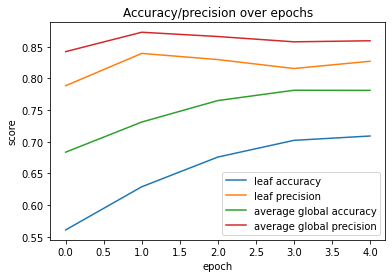

In [85]:
import matplotlib.pyplot as plt

trained_model = None
if TRAIN_FROM_SCRATCH:
    trained_model, val_metrics = train_model(
        config,
        train_loader, 
        val_loader, 
        model,
        CHECKPOINT_PATH,
        BEST_CHECKPOINT_PATH,
        level_sizes
    )
    x = np.arange(config['epochs'])
    fig, ax = plt.subplots()  # Create a figure and an axes.
    ax.plot(x, val_metrics[0], label='leaf accuracy')
    ax.plot(x, val_metrics[1], label='leaf precision')
    ax.plot(x, val_metrics[2], label='average global accuracy')
    ax.plot(x, val_metrics[3], label='average global precision')
    ax.set_xlabel('epoch')  # Add an x-label to the axes.
    ax.set_ylabel('score')  # Add a y-label to the axes.
    ax.set_title("Accuracy/precision over epochs")  # Add a title to the axes.
    ax.legend()  # Add a legend.
    fig.show()
else:
    load_path = '{}/{}_{}.pt'.format(folder_name, LOAD_ITERATION, 'best' if LOAD_BEST else 'current')
    trained_model = load_checkpoint(load_path, model)

In [86]:
test_result = run_model(trained_model, test_loader, level_sizes)

  0%|          | 0/46 [00:00<?, ?it/s]

# Evaluation

In [87]:
test_outputs = test_result['outputs']
test_targets = test_result['targets']
test_outputs

array([[4.70468258e-05, 1.62299003e-07, 2.07610835e-08, ...,
        1.46002880e-11, 2.57533744e-14, 1.92948825e-12],
       [1.52327481e-03, 3.87390864e-05, 8.48502992e-08, ...,
        1.07292543e-11, 5.04839877e-13, 7.08098372e-11],
       [5.85919991e-02, 9.72403027e-03, 1.24092683e-01, ...,
        1.75151508e-03, 6.73273287e-04, 1.92566135e-03],
       ...,
       [1.21774946e-07, 3.02220633e-05, 1.69163384e-03, ...,
        5.91008442e-09, 2.94934956e-08, 1.26142776e-08],
       [3.56960227e-05, 8.65429683e-06, 5.03499577e-05, ...,
        4.88979912e-10, 1.57180019e-10, 4.82382412e-10],
       [9.43888612e-09, 7.72746080e-06, 2.55669089e-04, ...,
        2.97330105e-10, 2.14007012e-09, 4.50826099e-10]])

In [88]:
get_metrics(test_result['outputs'], test_result['targets'], level_sizes)

# Rectified leaf AU(PRC) due to an sklearn bug.
# We add one artificial example that belongs to all classes at once and a corresponding prediction
# full of true positives. This way each class has at least one true positive, even if the test set
# does not contain enough examples to cover all classes.
rectified_outputs = np.concatenate([test_result['outputs'][:, level_offsets[-2]:], np.ones((1, level_sizes[-1]))], axis=0)
rectified_targets = np.concatenate([test_result['targets'][:, level_offsets[-2]:], np.ones((1, level_sizes[-1]), dtype=bool)], axis=0)

print('\n')
print('Rectified leaf-level AU(PRC) score:', metrics.average_precision_score(rectified_targets, rectified_outputs))

Level 0:
Accuracy: 0.8568493150684932
Precision: 0.8903512491257273 

Level 1:
Accuracy: 0.708904109589041
Precision: 0.8283747900485414 

Path average:
Accuracy: 0.7828767123287671
Precision: 0.8593630195871343


Rectified leaf-level AU(PRC) score: 0.7558325150776726
